<a href="https://colab.research.google.com/github/Foundsheep/aiffel_exploration/blob/main/%5BE_16%5DProject_Session_Based_Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트 - Movielens 영화 SBR
---
#### 배경
- 2015 RecSys Yoochoose 데이터를 통해 session_based 추천 시스템을 만들어봤다.(RNN 사용)
- `Movielens 1M Dataset` 데이터셋을 통해 비슷한 과정을 깊게 이해하고 재현해보자

In [1]:
# 데이터 다운로드
!wget http://files.grouplens.org/datasets/movielens/ml-1m.zip

--2022-03-14 00:34:34--  http://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  11.6MB/s    in 0.5s    

2022-03-14 00:34:35 (11.6 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]



In [2]:
!pwd

/content


In [3]:
!ls

ml-1m.zip  sample_data


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 데이터 불러오기
---

In [5]:
from pathlib import Path
import pandas as pd
import numpy as np
import tensorflow as tf

data_path = Path('/content/drive/MyDrive/e_16_project/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [6]:
# 주요 라이브러리 version 확인
print(tf.__version__)
print(pd.__version__)
print(np.__version__)

2.8.0
1.3.5
1.21.5


In [7]:
# 데이터 타입 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000209 entries, 31 to 1000042
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   UserId  1000209 non-null  int32
 1   ItemId  1000209 non-null  int32
 2   Rating  1000209 non-null  int32
 3   Time    1000209 non-null  int64
dtypes: int32(3), int64(1)
memory usage: 26.7 MB


> #### note:
> - `data['Time']`은 시간 관련 자료형인데 `int64` 자료형을 쓰는 이유가 궁금하다.
> - UTC time이 포함된 시간 자료형은 관습적으로 `int64`로 쓰나?
> - 저게 진짜 시간을 의미하는지 확인해보기 위해 아래의 코드를 찾아봤다.
> - 이를 통해 저 숫자의 의미를 이해할 수 있게 된 것 같다.

In [8]:
# int로 된 시간을 Timestamp 자료형으로 만드는 방법
temp_date = pd.to_datetime(data['Time'][0], unit='s', origin='unix')
temp_date

Timestamp('2000-12-31 22:12:40')

In [9]:
# 반대로 int로 바꾸는 방법
pd.to_datetime([temp_date]).view(int) / 10**9

array([9.7830076e+08])

#### 주의할 점
----
- 해당 데이터셋은 SessionId 대신 UserId가 들어가 있음(그래서 UserId를 SessionId로 여길 것)
- 실습 시 없었던 Ratings(선호도) 데이터는 어떻게 사용할 수 있을지 고민
- `Time` 항목은 UTC time으로서 1970년 1월 1일 이후 경과된 초 단위 시간

In [10]:
# 헷갈릴 수 있으니 UserId 컬럼명을 SessionId로 바꾸기
df = data.copy()
df.rename(columns={'UserId':'SessionId'}, inplace=True)

# 혹시 모르니 SessionId와 Time을 기준으로 sorting하기
df = df.sort_values(['SessionId', 'Time'])
df.head()

,SessionId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


### Step 1. 데이터의 전처리
---

##### `SessionId`, `ItemId` 개수 확인

In [11]:
# 유니크한 SessionId 개수 확인
print(f"unique number of sessions : {df['SessionId'].nunique()}")
print(f"unique number of items    : {df['ItemId'].nunique()}")

unique number of sessions : 6040
unique number of items    : 3706


In [12]:
# 첫날짜와 마지막 날짜 확인하기
date_beginning = pd.to_datetime(df['Time'][0], unit='s', origin='unix')
date_end = pd.to_datetime(df['Time'].iloc[-1], unit='s', origin='unix')

print(date_beginning, date_end)

2000-12-31 22:12:40 2001-08-20 13:44:15


In [13]:
# 하루 동안의 세션 개수 확인
round(df['SessionId'].nunique() / (date_end - date_beginning).days, 2)

26.15

> #### note:
> - 쓸데없는 상상이지만, 만약 **저 정도 규모의 세션을 갖는 서비스가 실제로 존재한다면 규모가 어느 정도일까?** 를 파악해보기 위해 약 6,000개의 세션이 얼마 기간 동안의 세션인지 확인해봤다.
> - 약 8개월 동안 6,000개라면 하루에 26개의 세션이란다... 참으로 작은 서비스이다...

##### Session Length(세션마다 몇 개의 클릭이 있었는지) 확인

In [14]:
session_length = df.groupby('SessionId').size()
session_length

SessionId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [15]:
# 이것도 맞나? 확인
# 인덱스로 정렬할 땐 .sort_index()
df['SessionId'].value_counts().sort_index()

1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Name: SessionId, Length: 6040, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


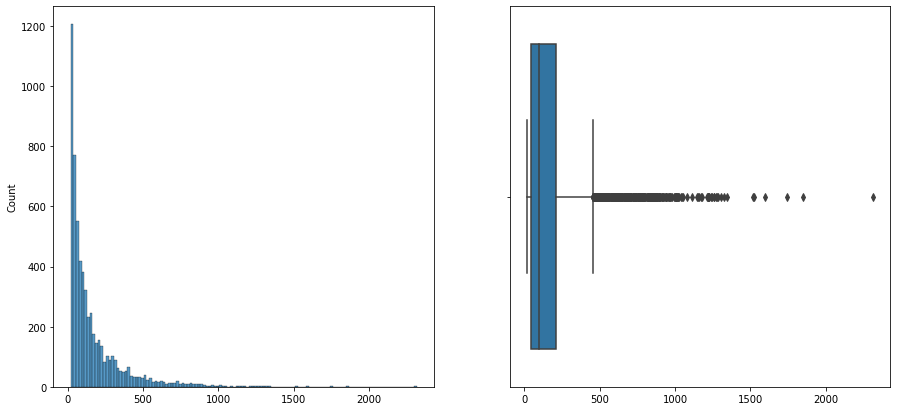

In [16]:
# 분포를 시각적으로 확인해보자
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15,7))
plt.subplot(121)
sns.histplot(session_length)

plt.subplot(122)
sns.boxplot(session_length)
plt.show()

In [17]:
# median, mean, std 등 확인
session_length.describe()

count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
dtype: float64

In [18]:
# 이상치 기준 판별
q1 = np.quantile(session_length, [0.25])
q3 = np.quantile(session_length, [0.75])
iqr = q3 - q1
upper_boundary = q3 + 1.5*iqr

upper_boundary

array([454.])

> #### note:
> - 세션당 클릭 수는 평균 `165개`라고 보면된다.(와우 8개월 내 세션 수는 처참할 정도였는데, 하나하나 세션이 갖는 아이템 클릭수는 엄청나다...)
> - 세션당 최소 클릭 수는 최소 `20개`이다.
> - 세션 클릭 수가 `455개` 이상인 것들부터는 이상치로 판별해도 되겠다.
> - 만약 그렇다면 클릭 수가 `454개`인 세션은 도대체 어느 시간동안 454개의 클릭을 했을까...?
> - 물론 이 모든 것은 UserId를 SessionId로 보다 보니 생긴 말도 안되는 가정이지만 한 번 확인해보기로 하자. 

In [19]:
# 세션 클릭 수 454개인 것 확인
# 1개만 나온다.
df.iloc[session_length[session_length == 454].index, :]

,SessionId,ItemId,Rating,Time
2644,22,1438,1,978136973


In [20]:
# 세션id 22의 클릭 아이템 및 시간 확인
df[df['SessionId'] == 22]

,SessionId,ItemId,Rating,Time
2582,22,1196,4,978134004
2695,22,1606,3,978134004
2780,22,1210,3,978134049
2840,22,2985,2,978134049
2783,22,1214,4,978134073
...,...,...,...,...
2809,22,3698,4,991149352
2709,22,1034,4,991149472
2623,22,3896,2,991149493
2646,22,908,4,991149661


In [21]:
print(f"세션 첫 클릭 시간 : {pd.to_datetime(df[df['SessionId'] == 22]['Time'].iloc[0], unit='s', origin='unix')}")
print(f"세션 끝 클릭 시간 : {pd.to_datetime(df[df['SessionId'] == 22]['Time'].iloc[-1], unit='s', origin='unix')}")

세션 첫 클릭 시간 : 2000-12-29 23:53:24
세션 끝 클릭 시간 : 2001-05-29 15:24:52


> #### note:
> - 음... 역시 다소 말이 안되는 상황이다...
> - 그렇다면 최소 클릭 수 `20`을 갖는 세션들은 얼마의 기간 동안 클릭들을 만들어냈는지 확인해보자.
> - 이를 통해 과장된 현재 데이터에서 그나마 현실적인 부분들이 있어서 해당 부분들만 품고 갈지, 아니면 어쩔 수 없이 현실적인 면은 포기한 채 모든 데이터를 품고 가야 할지 판단해보자.

In [22]:
sessionids_with_20_clicks = df.iloc[session_length[session_length == 20].index, :]['SessionId'].unique()
sessionids_with_20_clicks

array([ 2,  3,  4,  5,  8,  9, 10, 12, 13, 15, 17, 18, 19, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 42, 44],
      dtype=int32)

In [23]:
# 위의 세션 id 중 8개의 첫 클릭 시작 시간 및 끝 클릭 시작 시간을 확인해보자
for id in (list(sessionids_with_20_clicks[:4]) + list(sessionids_with_20_clicks[-4:])):
    print(f'세션 id : {id}')
    print(f"\t세션 첫 클릭 시간 : {pd.to_datetime(df[df['SessionId'] == id]['Time'].iloc[0], unit='s', origin='unix')}")
    print(f"\t세션 끝 클릭 시간 : {pd.to_datetime(df[df['SessionId'] == id]['Time'].iloc[-1], unit='s', origin='unix')}")

세션 id : 2
	세션 첫 클릭 시간 : 2000-12-31 21:28:44
	세션 끝 클릭 시간 : 2000-12-31 22:02:54
세션 id : 3
	세션 첫 클릭 시간 : 2000-12-31 21:10:18
	세션 끝 클릭 시간 : 2000-12-31 21:35:04
세션 id : 4
	세션 첫 클릭 시간 : 2000-12-31 20:18:44
	세션 끝 클릭 시간 : 2000-12-31 20:24:42
세션 id : 5
	세션 첫 클릭 시간 : 2000-12-31 05:37:52
	세션 끝 클릭 시간 : 2000-12-31 07:09:45
세션 id : 37
	세션 첫 클릭 시간 : 2000-12-28 23:32:55
	세션 끝 클릭 시간 : 2000-12-29 02:35:58
세션 id : 39
	세션 첫 클릭 시간 : 2000-12-28 22:42:52
	세션 끝 클릭 시간 : 2000-12-28 23:00:02
세션 id : 42
	세션 첫 클릭 시간 : 2000-12-28 21:29:41
	세션 끝 클릭 시간 : 2000-12-28 22:19:56
세션 id : 44
	세션 첫 클릭 시간 : 2000-12-28 15:45:57
	세션 끝 클릭 시간 : 2001-10-30 03:23:16


> #### note:
> - 오... 클릭 수가 20개인 것들은 나름 실제 `세션당 클릭`으로 봐도 될 정도로 첫 클릭과 마지막 클릭의 gap이 별로 나지 않는 것들도 있다.
> - 하지만 모든 것들이 다 그러진 않기에 **'클릭 수가 적은 세션들만 추려서 현실적인 데이터로 변환해 사용해보자'** 라는 건 위험한 것 같다.
> - `세션당 클릭 수`는 다소 현실적이지 않지만, 어쩔 수 없이 다 품고 가야할 것 같다.
> - 그러면 `세션당 클릭간 시간`을 기준으로 했을 땐 많은 데이터를 포함하면서 현실적으로 만들 수 있을까?

##### Session Time(첫 클릭 시간과 끝 클릭 시간 확인)
- 현재까지 파악한 것으로는 한 세션으로 보여도 실제 세션이 아니기 때문에 Time 컬럼 내 첫 클릭과 끝 클릭의 gap이 비현실적인 게 많았다.
- 실제로 세션당 두 값의 차이가 얼마인지 확인해보고 추려서 사용할 수 있을지 확인해보자

In [24]:
# 두 값간 차이 Series 만들기
between_clicks_2 = df.groupby('SessionId')['Time'].max() - df.groupby('SessionId')['Time'].min()

In [25]:
# 두 값간 차이 Series 만들기
between_clicks = df.groupby('SessionId')['Time'].max().apply(lambda x: pd.to_datetime(x, unit='s')) \
- df.groupby('SessionId')['Time'].min().apply(lambda x: pd.to_datetime(x, unit='s'))

between_clicks

SessionId
1        6 days 01:38:52
2        0 days 00:34:10
3        0 days 00:24:46
4        0 days 00:05:58
5        0 days 01:31:53
              ...       
6036     0 days 12:44:07
6037     1 days 01:47:23
6038     0 days 02:52:57
6039     0 days 14:41:11
6040   481 days 14:38:43
Name: Time, Length: 6040, dtype: timedelta64[ns]

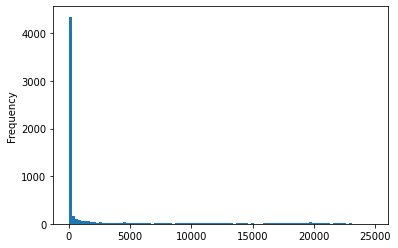

In [26]:
# 시 단위로 세션당 클릭간 갭을 바꾸고 히스토그램으로 확인해보기
between_clicks.astype('timedelta64[h]').plot(kind='hist', bins=100)

> #### note:
> - 뭔가 갭이 작은 것들의 수가 꽤 많은 것 같긴 한데 몇 프로 정도를 차지하는지 확인하기가 어렵다.
> - 전체 갭들의 몇 프로 정도가 현실적인 세션당 클릭간 갭으로 볼 수 있는지 확인해보자.

In [27]:
# 초 단위는 너무 경우의 수가 많아지니
# 시 단위로 세션당 클릭간 갭 확인
between_clicks_sorted = between_clicks.astype('timedelta64[h]').sort_values()
between_clicks_sorted

SessionId
5497        0.0
2551        0.0
2552        0.0
2553        0.0
4719        0.0
         ...   
5636    24067.0
5682    24150.0
5654    24286.0
5950    24775.0
5948    24791.0
Name: Time, Length: 6040, dtype: float64

In [28]:
# cumulative percent로 바꾸기
gap_count = between_clicks_sorted.groupby(between_clicks_sorted).size()
gap_count_cumsum_percent = gap_count.cumsum() / gap_count.sum()
gap_count_cumsum_percent_999 = gap_count_cumsum_percent[gap_count_cumsum_percent < 0.999]

gap_count_cumsum_percent_999

Time
0.0        0.481788
1.0        0.554967
2.0        0.575993
3.0        0.585596
4.0        0.591722
             ...   
23627.0    0.998179
23746.0    0.998344
23756.0    0.998510
23884.0    0.998675
23919.0    0.998841
Name: Time, Length: 1756, dtype: float64

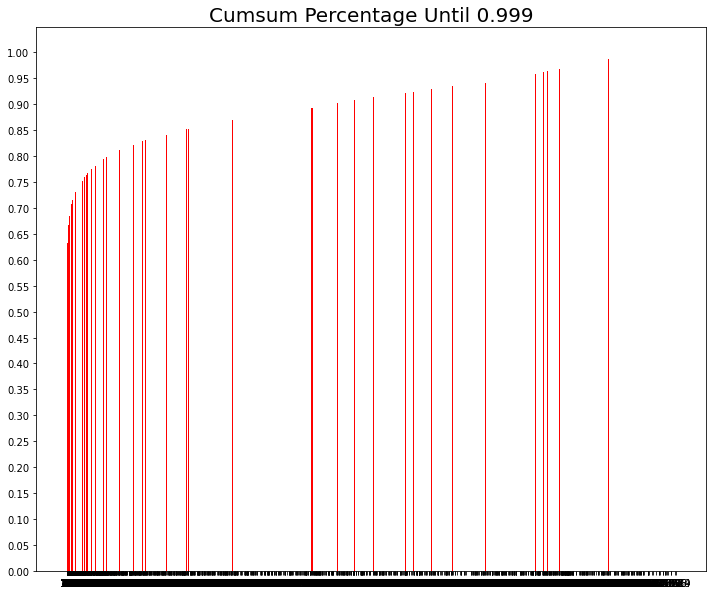

In [29]:
# 시각화하기
plt.figure(figsize=(12, 10))
plt.bar(x=gap_count_cumsum_percent_999.index,
        height=gap_count_cumsum_percent_999, color='red')
plt.xticks(gap_count_cumsum_percent_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

> #### note:
> - 한 75% ~ 80% 정도 사이의 갭들이 작은 부분에 많이 몰려 있음을 알 수 있다.
> - 거기에 있는 갭들은 어떤 값을 갖는지 확인해보자.

In [30]:
# 전체의 80% 미만인 것들 확인
gap_count_cumsum_percent[gap_count_cumsum_percent < 0.8]

Time
0.0       0.481788
1.0       0.554967
2.0       0.575993
3.0       0.585596
4.0       0.591722
            ...   
1556.0    0.799172
1559.0    0.799338
1562.0    0.799503
1563.0    0.799669
1573.0    0.799834
Name: Time, Length: 583, dtype: float64

> #### note:
> - 1573시간은 약 65일이다...
> - 이런 식으로 접근하면 안될 것 같고, 차라리 갭이 8시간 이내인 것들은 몇 프로를 차지하는지 확인해보자.

In [31]:
# gap 자체가 8이하인 것들 확인
gap_count_cumsum_percent[gap_count_cumsum_percent.index <= 8]

Time
0.0    0.481788
1.0    0.554967
2.0    0.575993
3.0    0.585596
4.0    0.591722
5.0    0.595364
6.0    0.598675
7.0    0.601490
8.0    0.602483
Name: Time, dtype: float64

> #### note:
> - 그나마 현실적인 8시간 갭으로 했을 대 60% 정도의 데이터가 그 안에 분포한다.
> - 그러면 8시간 내의 데이터만 추려서 사용해보자.

In [32]:
# gap이 8 이하인 것들의 sessionid 확인
sessionid_for_use = between_clicks_sorted[between_clicks_sorted <= 8].index
sessionid_for_use

Int64Index([5497, 2551, 2552, 2553, 4719, 2556, 2558, 2560, 4714, 2562,
            ...
            5542,  197, 3738, 4408, 3310, 5435, 2389, 3180, 5699,  199],
           dtype='int64', name='SessionId', length=3639)

In [33]:
mask = df['SessionId'].apply(lambda x: x in sessionid_for_use)

# 수정된 df 만들기
mdf = df.loc[mask, :]

# 위의 인덱스만 추려서 가져온 게 맞는지 확인
print(mdf['SessionId'].nunique() == len(sessionid_for_use))

True


> #### note:
> - 세션 내 클릭간 갭이 8시간 이하인 것들로 추렸다. 과연 이렇게 했을 경우 전체 데이터의 세션별 날짜 분포는 어떻게 될까?
> - 세션별 추천은 최근 데이터에 민감하기 때문에 데이터 분포 확인을 통해 가장 최근의 데이터들을 사용하는 게 좋다.
> - `70일` 이내의 분포가 어느 정도 많다고 판단될 경우 `최근 70일` 데이터를 사용하기로 하고, 아니면 분포가 몰려있는 지점의 데이터를 사용하자.
> - `70일`로 정한 이유는 여러 시도 끝에 적절한 수의 train, val, test 셋을 갖기 위해서이다.

In [34]:
# 함수화하기
def get_time(second):
    return pd.to_datetime(second, unit='s', origin='unix')

# 전체 데이터 내 첫 클릭 시간과 마지막 클릭 시간 확인
get_time(mdf['Time'].min()), get_time(mdf['Time'].max())

(Timestamp('2000-04-25 23:53:47'), Timestamp('2001-05-15 22:49:19'))

In [35]:
# 현재 전체 데이터셋의 세션별 날짜 분포 확인
from datetime import datetime as dt

temp_dates = mdf.groupby('SessionId')['Time'].min().apply(lambda x: get_time(x).date())
temp_dates.sort_values()

SessionId
6038    2000-04-25
6007    2000-04-26
6008    2000-04-26
6009    2000-04-26
6012    2000-04-26
           ...    
5       2000-12-31
4       2000-12-31
3       2000-12-31
2       2000-12-31
159     2001-05-15
Name: Time, Length: 3639, dtype: object

In [36]:
# cumulative percent로 바꾸기
date_count = temp_dates.groupby(temp_dates).size()
date_count_cumsum_percent = date_count.cumsum() / date_count.sum()
date_count_cumsum_percent_999 = date_count_cumsum_percent[date_count_cumsum_percent < 0.999]

date_count_cumsum_percent_999

Time
2000-04-25    0.000275
2000-04-26    0.006320
2000-04-27    0.008244
2000-04-28    0.011816
2000-04-29    0.013465
                ...   
2000-12-26    0.987084
2000-12-27    0.991206
2000-12-28    0.993954
2000-12-29    0.995603
2000-12-30    0.997527
Name: Time, Length: 250, dtype: float64

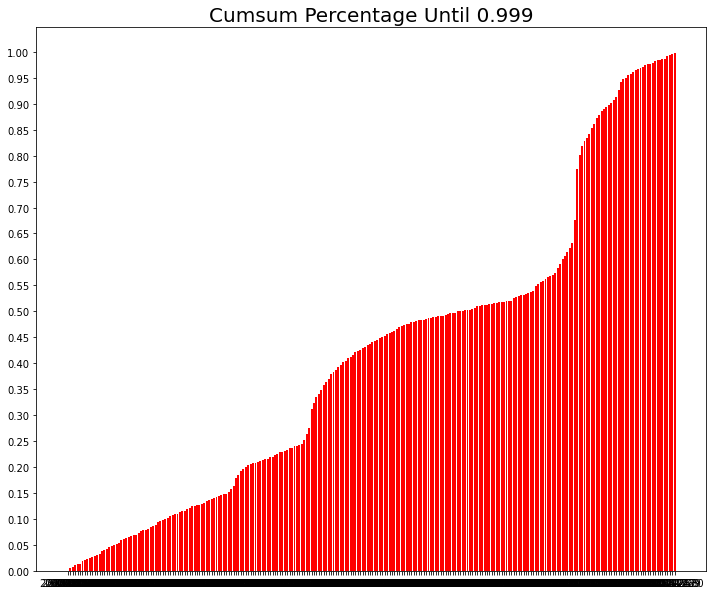

In [37]:
# 시각화하기
plt.figure(figsize=(12, 10))
plt.bar(x=date_count_cumsum_percent_999.index,
        height=date_count_cumsum_percent_999, color='red')
plt.xticks(date_count_cumsum_percent_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

> #### note:
> - 날짜들이 굉장히 고르게 분포해있는 것을 볼 수 있다.
> - 그럼 `2000-12-31`을 기준으로 70일 전 데이터는 몇 개의 세션을 담고 있는지 확인해보자.

In [38]:
# date 형식으로 써있는 컬럼 만들기
mdf['cvt_time'] = ''
mdf.loc[:, 'cvt_time']= mdf['Time'].map(lambda x: get_time(x).date())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [39]:
# 잘됐는지 확인
from IPython.display import display

display(mdf.head())
display(mdf.tail())

,SessionId,ItemId,Rating,Time,cvt_time
130,2,1198,4,978298124,2000-12-31
64,2,1210,4,978298151,2000-12-31
71,2,1217,3,978298151,2000-12-31
134,2,2717,3,978298196,2000-12-31
88,2,1293,5,978298261,2000-12-31


,SessionId,ItemId,Rating,Time,cvt_time
999738,6038,1296,5,956714684,2000-04-26
999739,6038,1354,3,956714725,2000-04-26
999725,6038,1419,4,956714815,2000-04-26
999741,6038,2700,1,956715051,2000-04-26
999731,6038,1183,5,956717204,2000-04-26


In [40]:
# outlier인  '2001-05-15'에 발생한 세션 제외해주기
import datetime

mdf2 = mdf[mdf['cvt_time'] <= datetime.date(2000, 12, 30)]
mdf2

,SessionId,ItemId,Rating,Time,cvt_time
1348,12,934,2,978218568,2000-12-30
1350,12,1641,3,978218568,2000-12-30
1356,12,999,4,978218568,2000-12-30
1357,12,2616,1,978218568,2000-12-30
1358,12,3785,3,978218568,2000-12-30
...,...,...,...,...,...
999738,6038,1296,5,956714684,2000-04-26
999739,6038,1354,3,956714725,2000-04-26
999725,6038,1419,4,956714815,2000-04-26
999741,6038,2700,1,956715051,2000-04-26


> #### note:
> - 보면 세션 내 클릭들을 8시간 이내로 줄였지만 2일에 걸쳐서 일어나는 것들이 있다.
> - 이런 것들은 데이터 정제의 편리성을 위해 제거하도록하겠다.

In [41]:
# 세션당 가지는 날짜의 수
# 2이상 되는 것들은 세션이 2일 이상에 걸쳐 일어났다는 것인데
# 추후 계산 편리상 제외하도록 함.
mdf2.groupby('SessionId')['cvt_time'].nunique()


SessionId
12      1
13      1
14      1
16      1
17      1
       ..
6032    1
6033    1
6034    1
6035    1
6038    2
Name: cvt_time, Length: 3630, dtype: int64

In [42]:
# 제외 전 
print(f"Before = whole dataset : {len(mdf2)}, unique sessions : {mdf2['SessionId'].nunique()}")


temp_mask = mdf2.groupby('SessionId')['cvt_time'].nunique() == 1
temp_mask = mdf2['SessionId'].isin(mdf2.groupby('SessionId').count()[temp_mask].reset_index()['SessionId'])
mdf3 = mdf2[temp_mask]

# 제외 후
print(f"After = whole dataset : {len(mdf3)}, unique sessions : {mdf3['SessionId'].nunique()}")

Before = whole dataset : 371667, unique sessions : 3630
After = whole dataset : 347387, unique sessions : 3489


In [43]:
# 잘 없어졌는지 확인
# 인덱스에 1만 있으면 된다.
mdf3.groupby('SessionId')['cvt_time'].nunique().value_counts()

1    3489
Name: cvt_time, dtype: int64

In [44]:
# 이를 토대로 세션당 클릭이 2000-12-30 이내 70일 사이에 일어난 세션들만 추린다.
mdf4 = mdf3[mdf3['cvt_time'] >= mdf3['cvt_time'].max() - datetime.timedelta(days=70)]

print(f"\n cvt_time range : {mdf4['cvt_time'].min()} ~ {mdf4['cvt_time'].max()} \n")

mdf4


 cvt_time range : 2000-10-21 ~ 2000-12-30 



,SessionId,ItemId,Rating,Time,cvt_time
1348,12,934,2,978218568,2000-12-30
1350,12,1641,3,978218568,2000-12-30
1356,12,999,4,978218568,2000-12-30
1357,12,2616,1,978218568,2000-12-30
1358,12,3785,3,978218568,2000-12-30
...,...,...,...,...,...
468137,2886,20,4,972151249,2000-10-21
468103,2886,485,4,972151276,2000-10-21
468117,2886,1562,5,972151276,2000-10-21
468107,2886,839,3,972151305,2000-10-21


In [45]:
# 현재까지 완료된 데이터의 feature별 데이터 수를 확인해본다.
print(f"rows : {len(mdf4)}")
print(f"unique session_ids : {mdf4['SessionId'].nunique()}")
print(f"unique item_ids : {mdf4['ItemId'].nunique()}")
print(f"unique days : {mdf4['cvt_time'].nunique()}")

rows : 164040
unique session_ids : 1683
unique item_ids : 3402
unique days : 70


> #### note:
> - 이렇게 70일 이내의 데이터만 남겨도 어느 정도 작은 규모로 학습할 수 있는 데이터 수는 충족하는 것 같다. 해당 범위의 날짜로 데이터를 사용하자.


> - 실습 때는 현재 데이터에서 클릭수가 적은 아이템은 제외하는 처리 과정을 거쳤다.
> - 하지만, 실제 추천 시스템에서도 클릭수가 적다는 이유만으로 추천 대상 데이터에서 제외될까?
> - 방금 막 올린 것이 아닌데도 클릭수가 적다는 것은 확실히 인기가 없을 만한 이유가 있는 것이고, 그것이 추천해주지 않을 만한 이유가 될 수도 있다고 생각한다.
> - 그러나, 일단 나는 여기서는 제외해보지 않을 생각이다.(뭔가 fair하게 기회를 줘보고 싶다...)

#### Train, Val, Test 데이터셋 나누기
 - 현재 총 70개 날짜의 데이터가 있는데, 앞 `46개`는 train, `6개` 날짜는 val, `18개` 날짜는 test로 놓도록 할 예정
 - 이렇게 나눈 이유는 날짜마다 세션의 수가 다른데, train, val, test 각각 적절한 수의 데이터를 확보하게 하기 위해서.

In [46]:
# 함수 정의
def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['cvt_time'].max()
    session_last_time = data.groupby('SessionId')['cvt_time'].max()
    session_in_train = session_last_time[session_last_time <= final_time - datetime.timedelta(n_days)].index
    session_in_test = session_last_time[session_last_time > final_time - datetime.timedelta(n_days)].index

    before_date = data[data['SessionId'].isin(session_in_train)]
    after_date = data[data['SessionId'].isin(session_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

In [47]:
# 나누는 함수 어떻게 작동되는지 확인 (1)
t_final_time = mdf4['cvt_time'].max()

t_session_last_time = mdf4.groupby('SessionId')['cvt_time'].max()

In [48]:
# 나누는 함수 어떻게 작동되는지 확인 (2)
t_final_time

datetime.date(2000, 12, 30)

In [49]:
# 나누는 함수 어떻게 작동되는지 확인 (3)
t_session_last_time[t_session_last_time <= t_final_time - datetime.timedelta(1)].max()

datetime.date(2000, 12, 29)

In [50]:
# 나누는 함수 어떻게 작동되는지 확인 (4)
t_session_last_time[t_session_last_time > t_final_time - datetime.timedelta(1)].max()

datetime.date(2000, 12, 30)

In [51]:
tr, test = split_by_date(mdf4, n_days=18)
tr, val = split_by_date(tr, n_days=6)

In [52]:
# data에 대한 정보를 살펴본다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Sessions: {data["SessionId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["cvt_time"].min()}\n'
          f'\t Last Time : {data["cvt_time"].max()}\n')

In [53]:
# 나눈 데이터 정보 확인
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 133979
	 Sessions: 1380
	 Items: 3368
	 First Time : 2000-10-21
	 Last Time : 2000-12-06

* valid Set Stats Info
	 Events: 15867
	 Sessions: 163
	 Items: 2473
	 First Time : 2000-12-07
	 Last Time : 2000-12-12

* test Set Stats Info
	 Events: 14158
	 Sessions: 140
	 Items: 2345
	 First Time : 2000-12-13
	 Last Time : 2000-12-30



In [54]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

> #### note:
> - 현재까지 진행된 데이터 전처리 과정 및 결과를 **정리**하자면,
> - `세션 길이`를 기준으로 했을 때는 최소 `20개` 클릭이 있고, 평균적으로 `165개`여서 비현실적이지만, 의미 없는 세션 길이는 없다고 생각하여 아무 데이터도 제외하지 않았고,
> - `세션 내 클릭간 갭`을 기준으로 했을 때는 `8시간` 이내에 이루어진 세션들 외에는 제외시켰다.(약 60%만 남김)
> - 그리고 오래되긴 했지만, SBR의 의미를 극대화하기 위해 이상치를 제외하고 비교적 `세션 내 클릭` 날짜가 최근 데이터인 `2000-12-31` 이전 70일 안으로 포함되는 데이터만 살렸다.
> - 그리고 이 때 `세션 내 클릭들`이 하루를 벗어나는 것들은 계산상 편의성을 위해 제외하였다.
> - 마지막으로 이 70개 날짜를 갖는 데이터를 `tr` _(1번째 날짜 ~ 46번째 날짜)_ , `val` _(47번째 날짜 ~ 52번째 날짜)_ , `test` _(53번째 날짜 ~ 70번째 날짜)_ 로 나누었다.

### Step 2. 미니 배치의 구성
---
- 여기서 `Session-parallel mini batch`라는 개념이 나오는데, 이 개념이 뭔지 헷갈렸다.
- 결과적으로 이해한 것을 요약하자면, 원래 RNN의 input은 저마다의 길이가 다른 문장 같은 것을 패딩 후에 다 길이를 같게 해서 input으로 넣어주지만(여기서 길이를 같게 한다는 것은 중요하지 않음), 현재 RNN input으로는 세션에 대한 정보를 벡터로 넣어줄 예정.
- 그런데 그 세션 벡터는 각각 클릭한 아이템 수가 다르니 여기서도 벡터간 요소 개수가 다른 현상이 발생.
- 어쩔 수 없이 세션 벡터를 길든 작든 하나씩 input으로 넣어주게 될 텐데, 여기서 parallel하게 시도한 것은 input으로 들어가는 걸 세션 벡터가 아니라 세션 내 같은 위치별 요소끼리(실제로 같지 않은 것들도 있지만) 벡터로 해서 input으로 넣는 것.
- 그리고 desired output은 그 요소들 다음에 클릭한 아이템 요소가 되도록 훈련하는 것
- 이 때 '그래도 세션당 길이가 다르면 결국 가서 요소들의 세션 내 위치 동일성이 흐트러지지 않냐'할 수 있는데, 여기서 보이는 이미지로는 그냥 훈련의 효율성(시간)을 위해 특정 세션의 요소가 다 끝나면 다르 세션 요소를 훈련 input 벡터에 결합시켜서 넣어줌
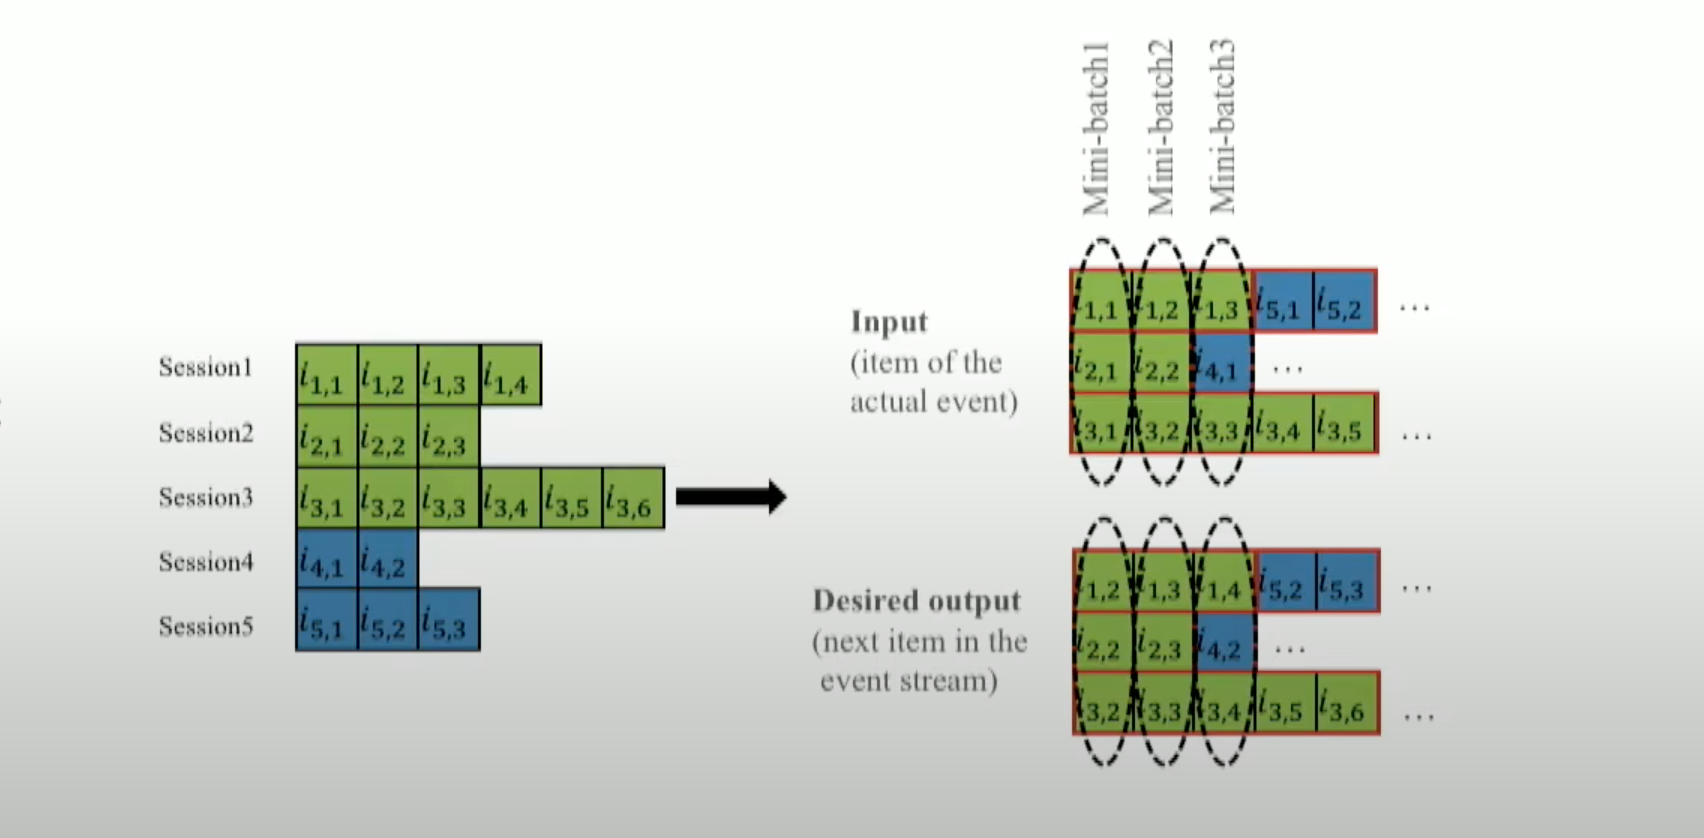 

#### Session-Dataset 만들기

In [55]:
# 세션 데이터셋 클랙스 정의
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

#### Session-Data-Loader 만들기

In [56]:
# 클래스 정의
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

### Step 3. 모델 구성
---


#### Evaluation Metric

In [57]:
# 함수 정의
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

#### Model Architecture

In [58]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [59]:
# 모델 정의
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [60]:
# args 클래스 정의
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

#### Model Training

In [61]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    metrics_list = [] # metrics 시각화용 리스트
    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.
        metrics_list.append((result[0], result[1], val_recall, val_mrr)) # metrics 시각화를 위해 모아놓기

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")
    return metrics_list

def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [62]:
# args 정의
args = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.001, epochs=30, k=20)

In [63]:
# 모델 생성
model = create_model(args)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(128, 1, 3368)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               513000    
                              (128, 50)]                         
                                                                 
 dropout (Dropout)           (128, 50)                 0         
                                                                 
 dense (Dense)               (128, 3368)               171768    
                                                                 
Total params: 684,768
Trainable params: 684,768
Non-trainable params: 0
_________________________________________________________________


## Step 4. 모델 학습
---

In [64]:
# 학습
history = train_model(model, args)

Evaluation:  30%|███       | 37/122 [00:43<01:40,  1.19s/it]


	 - Recall@20 epoch 1: 0.125633
	 - MRR@20    epoch 1: 0.026439



Evaluation:  30%|███       | 37/122 [00:42<01:36,  1.14s/it]


	 - Recall@20 epoch 2: 0.150971
	 - MRR@20    epoch 2: 0.035562



Evaluation:  30%|███       | 37/122 [00:41<01:34,  1.11s/it]


	 - Recall@20 epoch 3: 0.198480
	 - MRR@20    epoch 3: 0.053230



Evaluation:  30%|███       | 37/122 [00:39<01:31,  1.08s/it]


	 - Recall@20 epoch 4: 0.242399
	 - MRR@20    epoch 4: 0.067498



Evaluation:  30%|███       | 37/122 [00:39<01:29,  1.06s/it]


	 - Recall@20 epoch 5: 0.279350
	 - MRR@20    epoch 5: 0.079807



Evaluation:  30%|███       | 37/122 [00:39<01:30,  1.07s/it]


	 - Recall@20 epoch 6: 0.297931
	 - MRR@20    epoch 6: 0.086580



Evaluation:  30%|███       | 37/122 [00:59<02:16,  1.60s/it]


	 - Recall@20 epoch 7: 0.313978
	 - MRR@20    epoch 7: 0.092776



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.02s/it]


	 - Recall@20 epoch 8: 0.322002
	 - MRR@20    epoch 8: 0.096060



Evaluation:  30%|███       | 37/122 [00:39<01:30,  1.06s/it]


	 - Recall@20 epoch 9: 0.327492
	 - MRR@20    epoch 9: 0.100849



Evaluation:  30%|███       | 37/122 [00:46<01:47,  1.27s/it]


	 - Recall@20 epoch 10: 0.327069
	 - MRR@20    epoch 10: 0.102993



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 11: 0.329814
	 - MRR@20    epoch 11: 0.104609



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.00s/it]


	 - Recall@20 epoch 12: 0.334248
	 - MRR@20    epoch 12: 0.106859



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 13: 0.334671
	 - MRR@20    epoch 13: 0.108587



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.00it/s]


	 - Recall@20 epoch 14: 0.331715
	 - MRR@20    epoch 14: 0.107540



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.01it/s]


	 - Recall@20 epoch 15: 0.334671
	 - MRR@20    epoch 15: 0.107923



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.00it/s]


	 - Recall@20 epoch 16: 0.334248
	 - MRR@20    epoch 16: 0.108282



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.01it/s]


	 - Recall@20 epoch 17: 0.332770
	 - MRR@20    epoch 17: 0.108189



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.00it/s]


	 - Recall@20 epoch 18: 0.332770
	 - MRR@20    epoch 18: 0.109051



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.01it/s]


	 - Recall@20 epoch 19: 0.330659
	 - MRR@20    epoch 19: 0.109019



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.00it/s]


	 - Recall@20 epoch 20: 0.330236
	 - MRR@20    epoch 20: 0.109079



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.00it/s]


	 - Recall@20 epoch 21: 0.326436
	 - MRR@20    epoch 21: 0.109376



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.00s/it]


	 - Recall@20 epoch 22: 0.329814
	 - MRR@20    epoch 22: 0.109262



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 23: 0.327069
	 - MRR@20    epoch 23: 0.107604



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.00s/it]


	 - Recall@20 epoch 24: 0.325591
	 - MRR@20    epoch 24: 0.107214



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.01s/it]


	 - Recall@20 epoch 25: 0.326014
	 - MRR@20    epoch 25: 0.106554



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.01it/s]


	 - Recall@20 epoch 26: 0.324113
	 - MRR@20    epoch 26: 0.106495



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 27: 0.322424
	 - MRR@20    epoch 27: 0.105865



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 28: 0.321157
	 - MRR@20    epoch 28: 0.105241



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.00s/it]


	 - Recall@20 epoch 29: 0.319046
	 - MRR@20    epoch 29: 0.104725



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.01s/it]

	 - Recall@20 epoch 30: 0.319679
	 - MRR@20    epoch 30: 0.104386



### Step 5. 모델 테스트
---
- Inference(테스트셋에 어느 정도의 성능을 내는지 확인)

In [65]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

# 예측하기
test_model(model, args, test)

Evaluation:  20%|██        | 22/109 [00:22<01:29,  1.03s/it]

	 - Recall@20: 0.299006
	 - MRR@20: 0.091365



### Step 6. 개선해보기 (1) - 학습률 수정
-----

- 하이퍼파라미터를 조정해보자.
- 첫번째 모델은 epoch 30 중에 10번째 epoch 즈음부터 학습이 거의 멈춰 있는 것을 볼 수 있다.
- 어쩌면 minima 부분에서의 `learning rate * gradient` 값이 커서 minima 부분으로 못 들어가는 걸 수도 있다.
- `learning_rate`을 줄여서 좀 더 오래까지 잘 수렴할 수 있도록 해보자. 0.001 -> 0.0005로 줄여봤다.

In [72]:
# args 정의
args_2 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.0005, epochs=30, k=20)

In [73]:
# 모델 생성
model_2 = create_model(args_2)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(128, 1, 3368)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               513000    
                              (128, 50)]                         
                                                                 
 dropout_1 (Dropout)         (128, 50)                 0         
                                                                 
 dense_1 (Dense)             (128, 3368)               171768    
                                                                 
Total params: 684,768
Trainable params: 684,768
Non-trainable params: 0
_________________________________________________________________


In [74]:
# 학습
history_2 = train_model(model_2, args_2)


Evaluation:  30%|███       | 37/122 [00:47<01:48,  1.27s/it]


	 - Recall@20 epoch 1: 0.121199
	 - MRR@20    epoch 1: 0.028657



Evaluation:  30%|███       | 37/122 [00:43<01:40,  1.18s/it]


	 - Recall@20 epoch 2: 0.126056
	 - MRR@20    epoch 2: 0.030037



Evaluation:  30%|███       | 37/122 [00:43<01:39,  1.17s/it]


	 - Recall@20 epoch 3: 0.124155
	 - MRR@20    epoch 3: 0.029167



Evaluation:  30%|███       | 37/122 [00:42<01:37,  1.15s/it]


	 - Recall@20 epoch 4: 0.139569
	 - MRR@20    epoch 4: 0.033595



Evaluation:  30%|███       | 37/122 [00:41<01:36,  1.13s/it]


	 - Recall@20 epoch 5: 0.158784
	 - MRR@20    epoch 5: 0.039440



Evaluation:  30%|███       | 37/122 [00:41<01:34,  1.11s/it]


	 - Recall@20 epoch 6: 0.177576
	 - MRR@20    epoch 6: 0.043755



Evaluation:  30%|███       | 37/122 [00:41<01:34,  1.11s/it]


	 - Recall@20 epoch 7: 0.207770
	 - MRR@20    epoch 7: 0.053242



Evaluation:  30%|███       | 37/122 [00:39<01:30,  1.07s/it]


	 - Recall@20 epoch 8: 0.241132
	 - MRR@20    epoch 8: 0.064619



Evaluation:  30%|███       | 37/122 [00:39<01:30,  1.07s/it]


	 - Recall@20 epoch 9: 0.258657
	 - MRR@20    epoch 9: 0.071334



Evaluation:  30%|███       | 37/122 [00:39<01:29,  1.06s/it]


	 - Recall@20 epoch 10: 0.273226
	 - MRR@20    epoch 10: 0.075834



Evaluation:  30%|███       | 37/122 [00:38<01:28,  1.05s/it]


	 - Recall@20 epoch 11: 0.291596
	 - MRR@20    epoch 11: 0.080572



Evaluation:  30%|███       | 37/122 [00:38<01:29,  1.05s/it]


	 - Recall@20 epoch 12: 0.301943
	 - MRR@20    epoch 12: 0.083942



Evaluation:  30%|███       | 37/122 [00:38<01:28,  1.04s/it]


	 - Recall@20 epoch 13: 0.305954
	 - MRR@20    epoch 13: 0.087520



Evaluation:  30%|███       | 37/122 [00:38<01:27,  1.03s/it]


	 - Recall@20 epoch 14: 0.312922
	 - MRR@20    epoch 14: 0.090320



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.02s/it]


	 - Recall@20 epoch 15: 0.315667
	 - MRR@20    epoch 15: 0.091369



Evaluation:  30%|███       | 37/122 [00:38<01:27,  1.03s/it]


	 - Recall@20 epoch 16: 0.318412
	 - MRR@20    epoch 16: 0.093816



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.02s/it]


	 - Recall@20 epoch 17: 0.324324
	 - MRR@20    epoch 17: 0.095543



Evaluation:  30%|███       | 37/122 [00:37<01:27,  1.03s/it]


	 - Recall@20 epoch 18: 0.326225
	 - MRR@20    epoch 18: 0.096872



Evaluation:  30%|███       | 37/122 [00:37<01:27,  1.02s/it]


	 - Recall@20 epoch 19: 0.330448
	 - MRR@20    epoch 19: 0.098810



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 20: 0.329814
	 - MRR@20    epoch 20: 0.100048



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.00it/s]


	 - Recall@20 epoch 21: 0.330870
	 - MRR@20    epoch 21: 0.101076



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.02s/it]


	 - Recall@20 epoch 22: 0.334671
	 - MRR@20    epoch 22: 0.101589



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 23: 0.336360
	 - MRR@20    epoch 23: 0.101842



Evaluation:  30%|███       | 37/122 [00:38<01:27,  1.03s/it]


	 - Recall@20 epoch 24: 0.338260
	 - MRR@20    epoch 24: 0.102937



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 25: 0.341216
	 - MRR@20    epoch 25: 0.104534



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 26: 0.339527
	 - MRR@20    epoch 26: 0.104844



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.02s/it]


	 - Recall@20 epoch 27: 0.337416
	 - MRR@20    epoch 27: 0.105382



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.01s/it]


	 - Recall@20 epoch 28: 0.337416
	 - MRR@20    epoch 28: 0.107210



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 29: 0.338894
	 - MRR@20    epoch 29: 0.107975



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]

	 - Recall@20 epoch 30: 0.336149
	 - MRR@20    epoch 30: 0.107068



In [75]:
# 테스트셋에 대한 예측
test_model(model_2, args_2, test)

Evaluation:  20%|██        | 22/109 [00:22<01:29,  1.03s/it]

	 - Recall@20: 0.319957
	 - MRR@20: 0.099179



> #### feedback:
> - 기대했던 것과 다르게 loss는 이번에도 잘 수렴하지 못했다.
> - 하지만 테스트셋에 대한 `Recall@20`과 `MRR@20`은 소폭 상승했다.
> - 그러나 획기적인 상승은 아니어서 이번 variation이 더 좋다고 단정지어 말하기는 힘들 것 같다. 특히, 계속 loss가 `5` 미만으로 잘 안 떨어지는 데는 이유가 있을 것 같다.
> - 모델 자체를 한 번 바꿔보자.

### Step 6. 개선해보기 (2) - 모델 수정
-----

- 모델을 바꿔보면 loss가 좀 더 잘 내려갈 수도 있지 않을까?
- GRU layer를 2개로 쌓아보자.

In [76]:
# 새로운 모델 정의
def create_model_2GRU(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, return_sequences=True, name='GRU')(inputs) # return_sequences=True 추가
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU_2')(gru) # 해당 라인 추가
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [77]:
# args 정의
# 마지막 args에서 변동 없음
args_3 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.0005, epochs=30, k=20)

In [78]:
# 모델 생성
model_3 = create_model_2GRU(args_3)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(128, 1, 3368)]          0         
                                                                 
 GRU (GRU)                   [(128, 1, 50),            513000    
                              (128, 50)]                         
                                                                 
 GRU_2 (GRU)                 [(128, 50),               15300     
                              (128, 50)]                         
                                                                 
 dropout_2 (Dropout)         (128, 50)                 0         
                                                                 
 dense_2 (Dense)             (128, 3368)               171768    
                                                                 
Total params: 700,068
Trainable params: 700,068
Non-trainab

In [79]:
# 학습
history_3 = train_model(model_3, args_3)


Evaluation:  30%|███       | 37/122 [00:42<01:38,  1.16s/it]


	 - Recall@20 epoch 1: 0.118454
	 - MRR@20    epoch 1: 0.028713



Evaluation:  30%|███       | 37/122 [00:44<01:41,  1.20s/it]


	 - Recall@20 epoch 2: 0.120988
	 - MRR@20    epoch 2: 0.028281



Evaluation:  30%|███       | 37/122 [00:43<01:39,  1.17s/it]


	 - Recall@20 epoch 3: 0.110431
	 - MRR@20    epoch 3: 0.023748



Evaluation:  30%|███       | 37/122 [00:42<01:38,  1.16s/it]


	 - Recall@20 epoch 4: 0.135135
	 - MRR@20    epoch 4: 0.031975



Evaluation:  30%|███       | 37/122 [00:41<01:36,  1.13s/it]


	 - Recall@20 epoch 5: 0.173775
	 - MRR@20    epoch 5: 0.042753



Evaluation:  30%|███       | 37/122 [00:40<01:34,  1.11s/it]


	 - Recall@20 epoch 6: 0.204181
	 - MRR@20    epoch 6: 0.049782



Evaluation:  30%|███       | 37/122 [00:40<01:32,  1.09s/it]


	 - Recall@20 epoch 7: 0.220228
	 - MRR@20    epoch 7: 0.054476



Evaluation:  30%|███       | 37/122 [00:40<01:32,  1.09s/it]


	 - Recall@20 epoch 8: 0.233742
	 - MRR@20    epoch 8: 0.057892



Evaluation:  30%|███       | 37/122 [00:40<01:32,  1.09s/it]


	 - Recall@20 epoch 9: 0.244299
	 - MRR@20    epoch 9: 0.061467



Evaluation:  30%|███       | 37/122 [00:39<01:30,  1.07s/it]


	 - Recall@20 epoch 10: 0.251478
	 - MRR@20    epoch 10: 0.064009



Evaluation:  30%|███       | 37/122 [00:39<01:29,  1.05s/it]


	 - Recall@20 epoch 11: 0.263091
	 - MRR@20    epoch 11: 0.067148



Evaluation:  30%|███       | 37/122 [00:39<01:29,  1.06s/it]


	 - Recall@20 epoch 12: 0.278505
	 - MRR@20    epoch 12: 0.071075



Evaluation:  30%|███       | 37/122 [00:39<01:29,  1.05s/it]


	 - Recall@20 epoch 13: 0.285473
	 - MRR@20    epoch 13: 0.075349



Evaluation:  30%|███       | 37/122 [00:38<01:28,  1.04s/it]


	 - Recall@20 epoch 14: 0.291385
	 - MRR@20    epoch 14: 0.077381



Evaluation:  30%|███       | 37/122 [00:38<01:28,  1.04s/it]


	 - Recall@20 epoch 15: 0.300676
	 - MRR@20    epoch 15: 0.080362



Evaluation:  30%|███       | 37/122 [00:38<01:27,  1.03s/it]


	 - Recall@20 epoch 16: 0.309122
	 - MRR@20    epoch 16: 0.082933



Evaluation:  30%|███       | 37/122 [00:38<01:27,  1.03s/it]


	 - Recall@20 epoch 17: 0.311867
	 - MRR@20    epoch 17: 0.085257



Evaluation:  30%|███       | 37/122 [00:38<01:27,  1.03s/it]


	 - Recall@20 epoch 18: 0.317356
	 - MRR@20    epoch 18: 0.086897



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.02s/it]


	 - Recall@20 epoch 19: 0.316934
	 - MRR@20    epoch 19: 0.087630



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.01s/it]


	 - Recall@20 epoch 20: 0.320735
	 - MRR@20    epoch 20: 0.088254



Evaluation:  30%|███       | 37/122 [00:37<01:27,  1.02s/it]


	 - Recall@20 epoch 21: 0.319890
	 - MRR@20    epoch 21: 0.090092



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.01s/it]


	 - Recall@20 epoch 22: 0.321368
	 - MRR@20    epoch 22: 0.091679



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.00s/it]


	 - Recall@20 epoch 23: 0.321368
	 - MRR@20    epoch 23: 0.091226



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.02s/it]


	 - Recall@20 epoch 24: 0.322213
	 - MRR@20    epoch 24: 0.092878



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.02s/it]


	 - Recall@20 epoch 25: 0.318201
	 - MRR@20    epoch 25: 0.091800



Evaluation:  30%|███       | 37/122 [00:37<01:27,  1.03s/it]


	 - Recall@20 epoch 26: 0.321579
	 - MRR@20    epoch 26: 0.093513



Evaluation:  30%|███       | 37/122 [00:38<01:27,  1.03s/it]


	 - Recall@20 epoch 27: 0.322002
	 - MRR@20    epoch 27: 0.092749



Evaluation:  30%|███       | 37/122 [00:37<01:27,  1.03s/it]


	 - Recall@20 epoch 28: 0.319046
	 - MRR@20    epoch 28: 0.093440



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.01s/it]


	 - Recall@20 epoch 29: 0.322424
	 - MRR@20    epoch 29: 0.093277



Evaluation:  30%|███       | 37/122 [00:37<01:27,  1.03s/it]

	 - Recall@20 epoch 30: 0.320735
	 - MRR@20    epoch 30: 0.093635



In [80]:
# 테스트셋에 대한 예측
test_model(model_3, args_3, test)

Evaluation:  20%|██        | 22/109 [00:31<02:04,  1.43s/it]

	 - Recall@20: 0.306463
	 - MRR@20: 0.089838



> #### feedback:
> - 내가 세팅을 잘 못한 건지 아님 원래 그런 건지... 여튼 GRU 레이어가 하나 추가됐어도 별반 다르지 않은 예측값을 보였다.
> - 학습 시 `val`검증 지표도 GRU 레이어 1개일 때와 거의 흡사했다.
> - 다만 모델이 살짝 더 복잡해져서인지 맥시멈 수치까지 올라가는 시간이 좀 더 걸렸다.(약 10 epoch -> 약 15 epoch)

### Step 6. 개선해보기 (3) - 데이터 변경
-----

- `Ratings` 자료를 어떻게든 이용해보자.
- 여기서는 데이터 전처리 과정에서 그냥 `Ratings` 값이 3점 미만인 것들은 없애고 훈련시켜볼 예정
- `val`이나 `test` 데이터는 현재 상태로 놔두고, 현재 train 데이터에서만 다시 전처리를 한다.(그래야 test에 영향을 주지 않는 것 같다. 평점 낮은 아이템을 클릭해볼 수도 있을 테니..)

In [85]:
# 수정 전과 후의 데이터 숫자 파악
print(f"Before : {len(tr)}")

# 수정
tr = tr[tr['Rating'] >= 3]

print(f"After : {len(tr)}")

Before : 133979
After : 112443


In [92]:
# 사라진 세션과 아이템들이 있을 테니 인덱싱 다시 실행
# 딕셔너리 다시 만들고
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

# 인덱싱 다시 실행
tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [93]:
# 확인
tr.head()

,SessionId,ItemId,Rating,Time,cvt_time,item_idx
78899,530,3072,4,976142471,2000-12-06,0
78904,530,3264,4,976142471,2000-12-06,1
78929,530,2159,5,976142471,2000-12-06,2
78971,530,2944,4,976142471,2000-12-06,3
78982,530,2022,5,976142471,2000-12-06,4


In [94]:
# 확인 (2)
tr['item_idx'].max()

3230

In [95]:
# 확인 (3)
tr['ItemId'].nunique()

3231

In [96]:
# args 정의
# 학습률 수정된 버전과 계속 동일함
args_4 = Args(tr, val, test, batch_size=128, hsz=50, drop_rate=0.1, lr=0.0005, epochs=30, k=20)

In [97]:
# 모델 생성
model_4 = create_model(args_4)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(128, 1, 3231)]          0         
                                                                 
 GRU (GRU)                   [(128, 50),               492450    
                              (128, 50)]                         
                                                                 
 dropout_4 (Dropout)         (128, 50)                 0         
                                                                 
 dense_4 (Dense)             (128, 3231)               164781    
                                                                 
Total params: 657,231
Trainable params: 657,231
Non-trainable params: 0
_________________________________________________________________


In [98]:
# 학습
history_4 = train_model(model_4, args_4)

Evaluation:  30%|███       | 37/122 [00:44<01:41,  1.19s/it]


	 - Recall@20 epoch 1: 0.124367
	 - MRR@20    epoch 1: 0.028903



Evaluation:  30%|███       | 37/122 [00:45<01:43,  1.22s/it]


	 - Recall@20 epoch 2: 0.128167
	 - MRR@20    epoch 2: 0.030305



Evaluation:  30%|███       | 37/122 [00:42<01:37,  1.15s/it]


	 - Recall@20 epoch 3: 0.132390
	 - MRR@20    epoch 3: 0.031512



Evaluation:  30%|███       | 37/122 [00:42<01:38,  1.15s/it]


	 - Recall@20 epoch 4: 0.135135
	 - MRR@20    epoch 4: 0.034202



Evaluation:  30%|███       | 37/122 [00:43<01:38,  1.16s/it]


	 - Recall@20 epoch 5: 0.119721
	 - MRR@20    epoch 5: 0.026825



Evaluation:  30%|███       | 37/122 [00:42<01:36,  1.14s/it]


	 - Recall@20 epoch 6: 0.147382
	 - MRR@20    epoch 6: 0.035197



Evaluation:  30%|███       | 37/122 [00:41<01:34,  1.11s/it]


	 - Recall@20 epoch 7: 0.175887
	 - MRR@20    epoch 7: 0.046903



Evaluation:  30%|███       | 37/122 [00:40<01:33,  1.11s/it]


	 - Recall@20 epoch 8: 0.205025
	 - MRR@20    epoch 8: 0.052102



Evaluation:  30%|███       | 37/122 [00:40<01:33,  1.10s/it]


	 - Recall@20 epoch 9: 0.225084
	 - MRR@20    epoch 9: 0.058949



Evaluation:  30%|███       | 37/122 [00:39<01:31,  1.07s/it]


	 - Recall@20 epoch 10: 0.239020
	 - MRR@20    epoch 10: 0.065150



Evaluation:  30%|███       | 37/122 [00:39<01:30,  1.07s/it]


	 - Recall@20 epoch 11: 0.259079
	 - MRR@20    epoch 11: 0.070028



Evaluation:  30%|███       | 37/122 [00:39<01:29,  1.06s/it]


	 - Recall@20 epoch 12: 0.273649
	 - MRR@20    epoch 12: 0.076380



Evaluation:  30%|███       | 37/122 [00:38<01:28,  1.05s/it]


	 - Recall@20 epoch 13: 0.292652
	 - MRR@20    epoch 13: 0.083318



Evaluation:  30%|███       | 37/122 [00:38<01:27,  1.03s/it]


	 - Recall@20 epoch 14: 0.302365
	 - MRR@20    epoch 14: 0.084223



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.02s/it]


	 - Recall@20 epoch 15: 0.312922
	 - MRR@20    epoch 15: 0.088372



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 16: 0.323057
	 - MRR@20    epoch 16: 0.091505



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.01s/it]


	 - Recall@20 epoch 17: 0.328970
	 - MRR@20    epoch 17: 0.095350



Evaluation:  30%|███       | 37/122 [00:37<01:26,  1.01s/it]


	 - Recall@20 epoch 18: 0.330236
	 - MRR@20    epoch 18: 0.096991



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.00s/it]


	 - Recall@20 epoch 19: 0.332137
	 - MRR@20    epoch 19: 0.097586



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.00s/it]


	 - Recall@20 epoch 20: 0.334882
	 - MRR@20    epoch 20: 0.097955



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.00s/it]


	 - Recall@20 epoch 21: 0.337416
	 - MRR@20    epoch 21: 0.098951



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.00it/s]


	 - Recall@20 epoch 22: 0.340372
	 - MRR@20    epoch 22: 0.101126



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.00it/s]


	 - Recall@20 epoch 23: 0.343328
	 - MRR@20    epoch 23: 0.102026



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 24: 0.342483
	 - MRR@20    epoch 24: 0.103305



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 25: 0.341639
	 - MRR@20    epoch 25: 0.104414



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.00s/it]


	 - Recall@20 epoch 26: 0.344172
	 - MRR@20    epoch 26: 0.105890



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.00it/s]


	 - Recall@20 epoch 27: 0.346917
	 - MRR@20    epoch 27: 0.106854



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]


	 - Recall@20 epoch 28: 0.348818
	 - MRR@20    epoch 28: 0.107338



Evaluation:  30%|███       | 37/122 [00:36<01:24,  1.00it/s]


	 - Recall@20 epoch 29: 0.347973
	 - MRR@20    epoch 29: 0.107676



Evaluation:  30%|███       | 37/122 [00:37<01:25,  1.01s/it]

	 - Recall@20 epoch 30: 0.349662
	 - MRR@20    epoch 30: 0.107676



In [99]:
# 테스트셋에 대한 예측
test_model(model_4, args_4, test)

Evaluation:  20%|██        | 22/109 [00:22<01:28,  1.02s/it]

	 - Recall@20: 0.318182
	 - MRR@20: 0.097130



> #### feedback:
> - `val` 검정에서는 수치가 조금 올라간 향상을 보인다.
> - 그러나 `test` 데이터셋 예측에서는 기존과 비슷한 결과를 보인다.

### Step 7. - 개선안들 시각화 및 결론
-----
- 첫번째 : 베이스라인
- 두번째 : 학습률 변경
- 세번째 : 모델 변경(학습률 수정버전 유지)
- 네번째 : 데이터 변경(학습률 수정버전 유지)

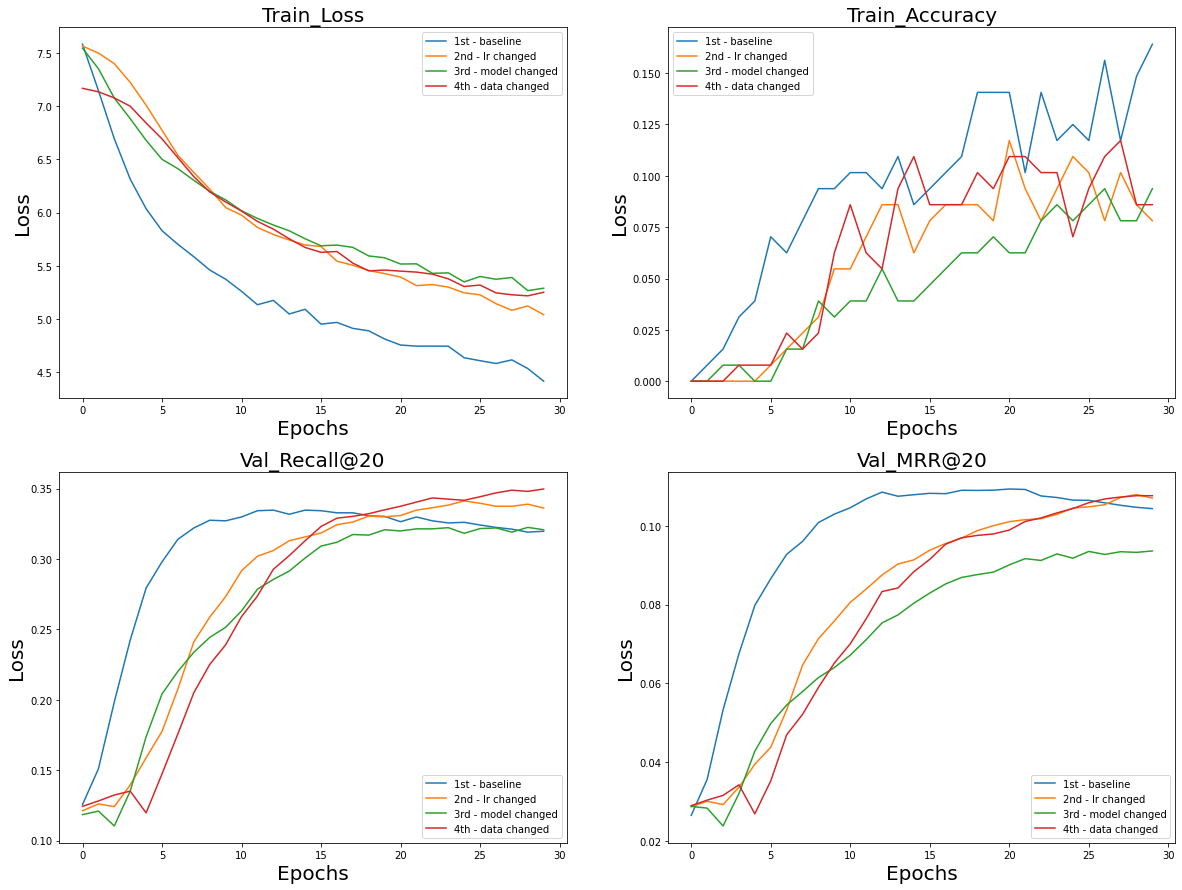

In [117]:
# 훈련 과정 시각화해보기

# 타이틀을 위한 지표 이름 리스트 생성
metrics_name = ['Train_Loss', 'Train_Accuracy', 'Val_Recall@20', 'Val_MRR@20']

# 시각화
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

for i in range(2):
    for j in range(2):
        if i == 0:
            axs[i][j].plot(np.array(history)[:, j], label='1st - baseline')
            axs[i][j].plot(np.array(history_2)[:, j], label='2nd - lr changed')
            axs[i][j].plot(np.array(history_3)[:, j], label='3rd - model changed')
            axs[i][j].plot(np.array(history_4)[:, j], label='4th - data changed')

            axs[i][j].set_title(metrics_name[j], fontsize=20)
            axs[i][j].set_xlabel("Epochs", fontsize=20)
            axs[i][j].set_ylabel("Loss", fontsize=20)
            axs[i][j].legend()
        else:
            axs[i][j].plot(np.array(history)[:, j+2], label='1st - baseline')
            axs[i][j].plot(np.array(history_2)[:, j+2], label='2nd - lr changed')
            axs[i][j].plot(np.array(history_3)[:, j+2], label='3rd - model changed')
            axs[i][j].plot(np.array(history_4)[:, j+2], label='4th - data changed')

            axs[i][j].set_title(metrics_name[j+2], fontsize=20)
            axs[i][j].set_xlabel("Epochs", fontsize=20)
            axs[i][j].set_ylabel("Loss", fontsize=20)
            axs[i][j].legend()

plt.show()

In [118]:
# 전체 모델 예측 지표 모아보기
print("1st - baseline")
test_model(model, args, test)
print()

print("2nd - learning_rate changed")
test_model(model_2, args_2, test)
print()

print("3rd - model structure changed")
test_model(model_3, args_3, test)
print()

print("4th - data modified")
test_model(model_4, args_4, test)
print()


1st - baseline


Evaluation:  20%|██        | 22/109 [00:28<01:52,  1.30s/it]


	 - Recall@20: 0.030540
	 - MRR@20: 0.007886


2nd - learning_rate changed


Evaluation:  20%|██        | 22/109 [00:26<01:46,  1.22s/it]


	 - Recall@20: 0.033381
	 - MRR@20: 0.007309


3rd - model structure changed


Evaluation:  20%|██        | 22/109 [00:32<02:09,  1.48s/it]


	 - Recall@20: 0.029474
	 - MRR@20: 0.006442


4th - data modified


Evaluation:  20%|██        | 22/109 [00:23<01:34,  1.09s/it]

	 - Recall@20: 0.319602
	 - MRR@20: 0.095283




### 결론
---
- Loss 부분을 보면 제일 처음 베이스라인 모델이 가장 잘 수렴하는 것으로 보인다.
- 하지만 val과 test 데이터셋에 대한 검증 및 예측을 보면 베이스라인보다는 다른 개선안들이 조금씩 좋은 모습을 보여줄 때가 있다.
- 가장 중요한 test 데이터 예측 측면에서는 4번째 세트(Rating 사용한)가 가장 무난하지 않나 싶다.

## 회고
#### Point 1) 데이터톤의 효과
- 데이터톤 덕분인지 처음에 전처리를 하면서 데이터를 볼 때 좀 더 진지하게 데이터를 바라보게 되었다.
- 어떤 게 outlier일지, 해당 값들은 어떤 이유에서 outlier일지, 데이터에 포함하는 게 맞는지 등 직접 데이터를 내 스스로 판단하고 정제해본 경험이 데이터를 바라보는 나의 의견에 좀 더 자신감을 불어넣어 주었다.

#### Point 2) 왜 추천을 RNN으로 학습해서 하는가...?
- 처음에 정말 이해가지 않았다.
- 실습 때 전처리 부분은 어느 정도 이해했는데, 뒷 부분부터 나오는 `Session-parallel mini batch` 구현과 RNN 모델을 쓴다는데 도대체 어떻게 이 모든 구조가 돌아가는 건지 등 뒷 부분은 전혀 이해가지 않았다.
- 그리고 논문도 슬쩍슬쩍 읽어봤지만 역시나 직관적으로 다가오지는 않았다.
- 그러다 한줄기 빛 같은 자료를 찾았는데, 바로 해당 논문의 저자로 보이는 사람이 추천시스템 기반 서비스에서 해당 알고리즘에 대해서 설명해주는 영상이었다.(https://youtu.be/M7FqgXySKYk)
- 결론적으로 해당 영상을 보고나서 '어떤 모양으로 `Session-parallel mini batch`를 구현하는 건지', '여기서 RNN은 어떤 이유에서 쓰이는 건지'에 대한 직관적 힌트를 얻고 코드를 하나하나 뜯어보면서 어느 정도 이해하게 됐다.(요약하면, 세션 내 클릭한 아이템 순서를 RNN이 학습해서 예측 시 특정 아이템 후에 어떤 아이템을 클릭할지 알려주는 알고리즘으로 이해했다.)
- 이러한 작은 경험 하나하나는 당시엔 괴롭지만, 끝에는 소중한 성공 경험과 무언가 모르는 것을 부딪힐 수 있는 근육을 키워주는 것 같다. 그렇기에 이번 프로젝트도 결과물과 상관없이 감사한 마음을 갖고 끝낼 수 있었다.

#### Point 3) Ratings 이용하기
- 이번 프로젝트를 하면서 가장 하고 싶었던 것은 `Ratings`를 이용해서 추천 성능을 더 높여보는 것이었다.
- 그것의 관건은 어느 부분에서 `Ratings` 자료를 어떻게 이용하느냐에 따른 것인데, 일단 내가 고미해본 부분은 아래와 같다.
  - 위의 영상에서 발표자가 말하길 `ItemId`와 `다른 feature(예 : 이미지)`를 concatenate 했다고 했다.
  - 그럼 나도 concatenate 할 수 있지 않을까? 싶었는데 코드를 뜯어보면서 생각해 보니 현재 `데이터 미니배치화`와 `모델 훈련`은 전반적으로 아이템 **순서**를 학습하는 것이다.
  - 그러면 여기 `ItemId`와 `Ratings`를 어떻게든 concatenate하면 되지 않을까? 싶지만,
  - `Ratings`는 사실 순서와 상관 없다... 그 값 자체가 높은 아이템이 추천되는 게 좋은 거지, 이렇게 저렇게 뭔가랑 엮어서 **sequential**한 학습을 하기엔 맞지 않는 자료라는 생각이 들었다.
  - 그리고 다른 방법으로는 '뭔가 모델을 두 개 짜서 하나는 **sequential**한 걸 학습하고, 다른 하나는 **Matrix Factorization**을 써서 두 개의 결과물을 이렇게 저렇게 합치고, Loss도 어떻게 구현해볼까...'하는 굉장히 거창한 생각이 들었지만 이건 지금의 나로서는 도저히 할 수 없는 것이었다.
  - 그래서 결론적으로 나는 현재 있는 모든 코드를 뜯어고칠 수는 없으니, **데이터 전처리 과정**에서 이를 구현해보기로 했다.
- 바로, `Ratings`가 높은 아이템만 sequnece에 살아남도록 하기...
- 참고로, 실제 영상 후반부에 누군가가 이와 정확히 떨어지는 주제에 관한 질문을 던진다('세션 기반에 대한 예측에 유저 기반의 데이터가 있다면 어떻게 합쳐서 personalized recommend를 할지 구현해봤냐?'). 그리고 발표자는 아직 해보지 않았지만, 좋은 포인트라고만 답변했다.

#### Point 4) `IndexError: index 5 is out of bounds for axis 0 with size 5`
- 아지트에서도 그렇고 나도 이번 프로젝트를 진행하면서 모델 훈련 시 위와 같은 `IndexError`를 겪었다.
- 해결법은 그냥 단순히 `batch_size`를 저 숫자보다 작게 하면 되는 건데 `왜 그런건지` 이유를 알고 싶었다.
- 자세히 오류를 들여다 보니 문제는 `val`데이터 검증 시 일어나는 거였다.
- 즉, `val` 데이터 자체의 개수(세션 개수)가 내가 정한 `batch_size`보다 작으면 `IndexError`를 내는 것이었다.
- 그리고 또 하나의 포인트는, 해당 `batch_size`가 train, val, test 데이터셋 모두 다 커버할 수 있어야 한다는 것이다. 하나의 모델로 훈련, 검증, 평가를 거치는 것이어서 val, test 데이터 모두 훈련 시 쓰는 `batch_size` 이상의 세션 개수를 가져야 하는 것이다.
- 전혀 예상하지 않았지만, 노드를 따라하다 보니 `val`의 개수와 `test` 데이터 개수를 굉장히 적게 가져갔는데, 이런 부분도 생각하면서 진행해야겠다...(컴퓨터는 우리가 시킨대로만 움직일 뿐...)